# Exploratory Data Analysis

In [1]:
import os
import glob
from collections import defaultdict
from PIL import Image

## 1. Initial data inspection
Data structure is organized into folders corresponding to your final three classes, separated by train/validation/test splits:

* **ejecta_train**: Corresponds to the New Crater class.
* **oldcrater_train**: Corresponds to the Old Crater class.
* **none_train1, none_train2, none_train3, none_train4**: Corresponds to the No Crater class.
* **test**: Contains test images for all classes.
* **val**: Contains validation images for all classes.

### 1.1. Check class imbalance

In [2]:
# Base directory
base_dir = "/Users/gracebraz/code/VMontejo/lunar-crater-age-classifier/raw_data/7041842"

# Map project class names to directory names
class_dirs = {
    "New Crater": "ejecta_train",
    "Old Crater": "oldcrater_train",
    "No Crater": ["none_train1", "none_train2", "none_train3", "none_train4"]
}

# Dict to store file counts
file_counts = defaultdict(int)

print("--- Counting Images in Training Directories ---")
for class_name, dir_names in class_dirs.items():
    # Handle single string or list of strings for directory names
    if isinstance(dir_names, str):
        dir_names = [dir_names]

    for dir_name in dir_names:
        full_path = os.path.join(base_dir, dir_name)
        count = len(glob.glob(os.path.join(full_path, "*.jpg")))
        file_counts[class_name] += count
        print(f"Directory '{dir_name}': {count} files found.")

total_train_files = sum(file_counts.values())

print("\n--- Training Set Class Distribution ---")
for class_name, count in file_counts.items():
    percentage = (count / total_train_files) * 100
    print(f"| {class_name:12s}: {count:5d} files ({percentage:.2f}%)")

print(f"Total Training Files: {total_train_files}")

--- Counting Images in Training Directories ---
Directory 'ejecta_train': 358 files found.
Directory 'oldcrater_train': 594 files found.
Directory 'none_train1': 421 files found.
Directory 'none_train2': 828 files found.
Directory 'none_train3': 641 files found.
Directory 'none_train4': 766 files found.

--- Training Set Class Distribution ---
| New Crater  :   358 files (9.92%)
| Old Crater  :   594 files (16.46%)
| No Crater   :  2656 files (73.61%)
Total Training Files: 3608


### 1.2. Image format and dimension check

In [ ]:
def inspect_sample_image(dir_path, class_name):
    # Find the first image file
    sample_file = glob.glob(os.path.join(dir_path, "*.jpg"))[0]

    with Image.open(sample_file) as img:
        print(f"\n--- Sample Image Details ({class_name}) ---")
        print(f"File: {os.path.basename(sample_file)}")
        print(f"Format: {img.format}")
        print(f"Mode: {img.mode}") # 'L' is grayscale, 'RGB' is color
        print(f"Size (Width, Height): {img.size}")

In [9]:
# Inspect one image from 'New Crater'
inspect_sample_image(os.path.join(base_dir, 'ejecta_train'), 'New Crater (ejecta)')


--- Sample Image Details (New Crater (ejecta)) ---
File: M159705621LC_pyr-0144.jpg
Format: JPEG
Mode: RGB
Size (Width, Height): (227, 227)


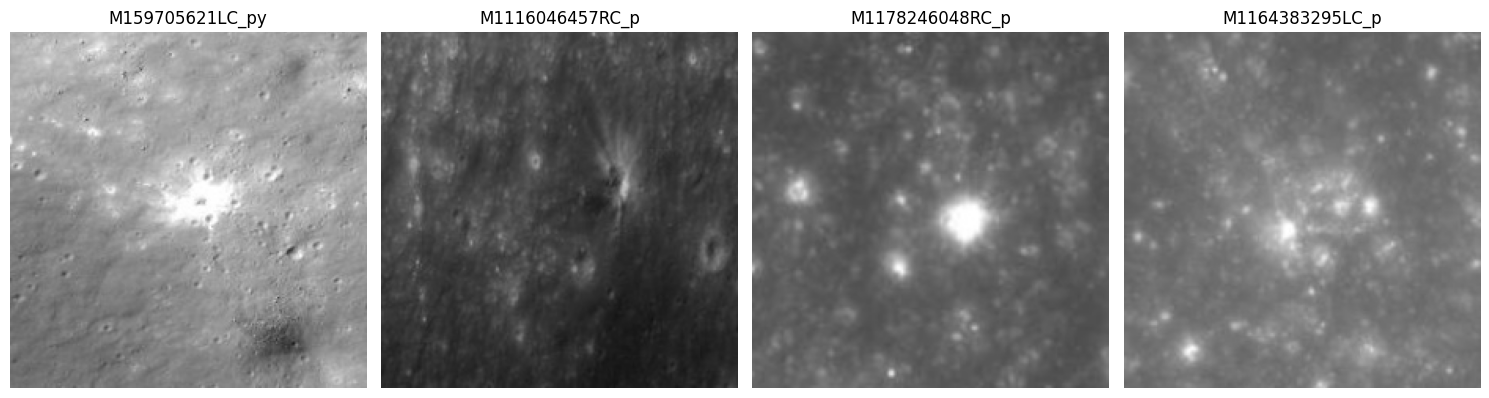

In [21]:
import matplotlib.pyplot as plt

# Get first 4 images from ejecta_train
image_dir = os.path.join(base_dir, "ejecta_train")
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')][:4]

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for ax, img_file in zip(axes, image_files):
    img = Image.open(os.path.join(image_dir, img_file))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_file[:15])

plt.tight_layout()
plt.show()

In [5]:
# Inspect one image from 'No Crater' (using the first 'none' folder)
inspect_sample_image(os.path.join(base_dir, 'none_train1'), 'No Crater (none)')


--- Sample Image Details (No Crater (none)) ---
File: M119217559LC_pyr-0815.jpg
Format: JPEG
Mode: RGB
Size (Width, Height): (227, 227)


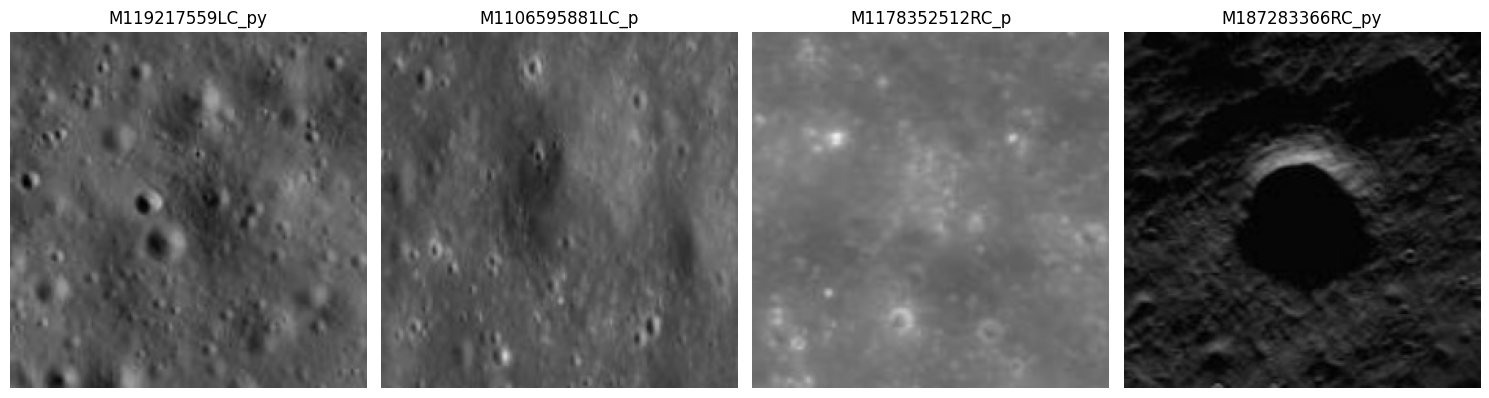

In [22]:
# Get first 4 images from none_train1
image_dir = os.path.join(base_dir, "none_train1")
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')][:4]

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for ax, img_file in zip(axes, image_files):
    img = Image.open(os.path.join(image_dir, img_file))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_file[:15])

plt.tight_layout()
plt.show()

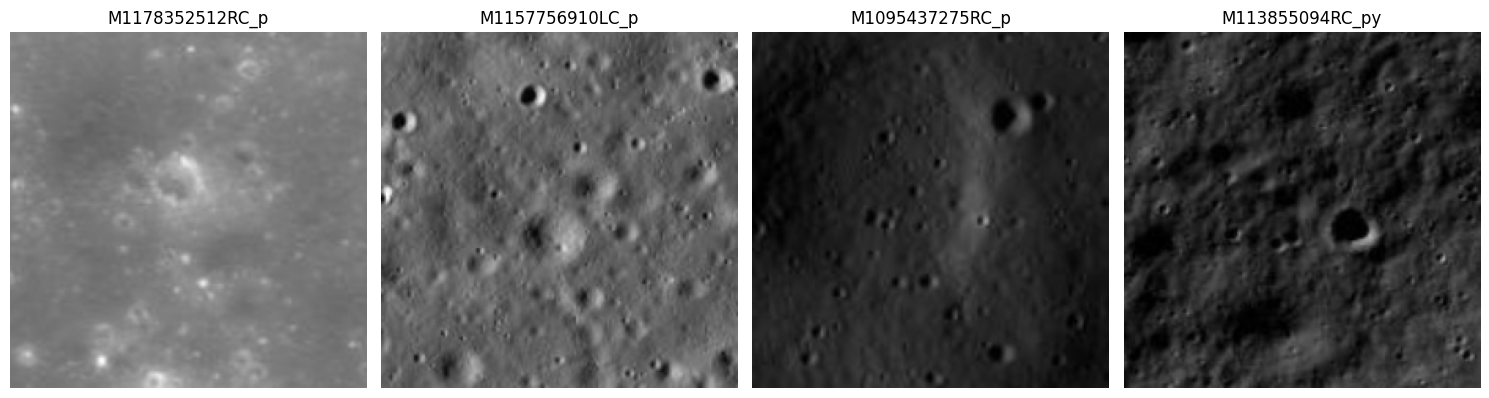

In [25]:
# Get first 4 images from old_crater
image_dir = os.path.join(base_dir, "oldcrater_train")
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')][:4]

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for ax, img_file in zip(axes, image_files):
    img = Image.open(os.path.join(image_dir, img_file))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_file[:15])

plt.tight_layout()
plt.show()

Mean RGB: [39.48854043 39.48854043 39.48854043]
Std RGB: [19.87649551 19.87649551 19.87649551]


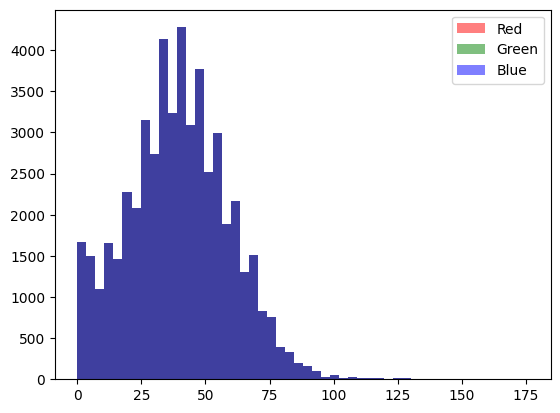

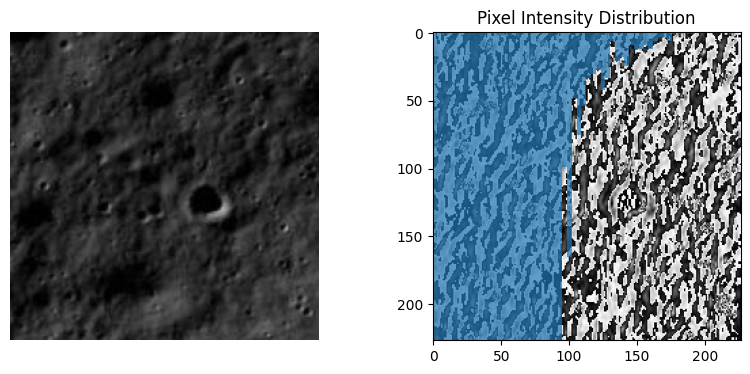

In [26]:
# 1. Check color distributions
import numpy as np
colors = np.array(img).reshape(-1, 3)
print(f"Mean RGB: {colors.mean(axis=0)}")
print(f"Std RGB: {colors.std(axis=0)}")

# 2. Visualize image histogram
plt.hist(colors[:, 0], bins=50, alpha=0.5, color='r', label='Red')
plt.hist(colors[:, 1], bins=50, alpha=0.5, color='g', label='Green')
plt.hist(colors[:, 2], bins=50, alpha=0.5, color='b', label='Blue')
plt.legend()

# 3. Plot pixel intensity distribution
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
plt.hist(np.array(img).ravel(), bins=50, alpha=0.7)
plt.title('Pixel Intensity Distribution')

# 4. Show edge detection (using PIL/SciPy)
from scipy import ndimage
gray = np.array(img.convert('L'))
edges = ndimage.sobel(gray)
plt.imshow(edges, cmap='gray')

# ⚙️ Data pipeline engineering: implementing class weights

#### Strategy: Calculating and Applying Class Weights

Instead of relying on random oversampling (weighted sampling), a common and often more robust method in Keras is to use a Weighted Loss Function. 
This means we train the model normally, but instances of the minority classes incur a much higher penalty (loss) when misclassified. The weight for any class $C$ is typically calculated as:$$\text{Weight}_C = \frac{\text{Total Samples}}{\text{Number of Classes} \times \text{Samples}_C}$$Required Coding Step: Collect all file paths and calculate these weights. This is the foundation for your efficient tf.data.Dataset pipeline.

In [28]:
from sklearn.utils.class_weight import compute_class_weight

# --- 1. Define training data structure ---
# base_dir

class_map = {
    "ejecta_train": 0,    # New Crater
    "oldcrater_train": 1, # Old Crater
    "none_train1": 2,     # No Crater (part 1)
    "none_train2": 2,     # No Crater (part 2)
    "none_train3": 2,     # No Crater (part 3)
    "none_train4": 2      # No Crater (part 4)
}

# --- 2. Collect all training labels ---
all_labels = []
for dir_name, class_label in class_map.items():
    full_path = os.path.join(base_dir, dir_name)
    num_files = len(glob.glob(os.path.join(full_path, "*.jpg")))
    # Append the corresponding class label for each file found
    all_labels.extend([class_label] * num_files)

# Convert to NumPy array for calculation
y_train_labels = np.array(all_labels)

# --- 3. Calculate Class Weights ---
# Define the unique class names and integer labels
class_names = ["New Crater", "Old Crater", "No Crater"]
classes = np.unique(y_train_labels)

# Use scikit-learn's utility function to calculate balanced weights
# This gives higher weights to the minority classes (New/Old Crater)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_labels
)

# Convert the array to a dictionary for Keras input
class_weights = dict(enumerate(class_weights_array))

print("\n--- Calculated Class Weights (for Keras fit) ---")
for label, weight in class_weights.items():
    print(f"| {class_names[label]:12s} (Label {label}): {weight:.3f}")


--- Calculated Class Weights (for Keras fit) ---
| New Crater   (Label 0): 3.359
| Old Crater   (Label 1): 2.025
| No Crater    (Label 2): 0.453
